In [1]:
# Revove Unwanted warning
import warnings
warnings.simplefilter(action='ignore', category = FutureWarning)

# Data extraction and management
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
from pandas_datareader import data as pdr
from pandas_datareader.nasdaq_trader import get_nasdaq_symbols
import yfinance as yf

#Feature Engineering
from sklearn.preprocessing import StandardScaler

# Machine Learning
from sklearn.cluster import KMeans
from sklearn import metrics
from kneed import KneeLocator

# Cointegration and Statistics
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [6]:
# Data Extraction
# Set Data Extraction parameters
start_date = "2017-01-01"
end_date = "2022-06-01"
file_name = "data/raw_data_etf.csv"
file_name_coint = "data/raw_data_coint_pairs.csv"
load_existing = False
load_coint_pairs = False

In [9]:
# Get New or Load existing Data
# Allow 15 mins for new data
if not load_existing:
    symbols = get_nasdaq_symbols()
    symbols = symbols[(symbols["ETF"] == True) & (symbols["Market Category"] == "G")] # G = NASDAQ GLOBAL MARKET
    symbols = list(symbols.index.values)
    # data    = 
    yf.pdr_override()
    # df = DataReader(name=symbol, data_source='yahoo', start=start_date, end=end_date)
    data = pdr.get_data_yahoo(symbols, start=start_date, end=end_date)["Adj Close"]
    data
    data.to_csv(file_name)
else:
    data = pd.read_csv(file_name)
# symbols 

[*********************100%***********************]  543 of 543 completed


97 Failed downloads:
['INFR', 'RNEW', 'UPWD', 'SDSI', 'BABX', 'PYPT', 'RUNN', 'BIGB', 'CAFG', 'STXK', 'FDIF', 'BKWO', 'BRNY', 'FDCF', 'UTRE', 'AMZD', 'FBL', 'AMZU', 'TWEB', 'MSFD', 'DYTA', 'PTEC', 'CCSO', 'QYLE', 'FTGS', 'MCSE', 'ERET', 'STXD', 'LITP', 'DVAL', 'TSLL', 'BKIV', 'COWG', 'MKAM', 'MEDX', 'UTWO', 'CLOA', 'AAPB', 'SPAQ', 'BDGS', 'BLLD', 'DIVD', 'PRVT', 'FBOT', 'TBIL', 'IBTM', 'FDTX', 'USCL', 'AAPD', 'EFRA', 'NIKL', 'TSL', 'UFIV', 'MODL', 'BSCW', 'USVN', 'OBIL', 'GGLL', 'TSLQ', 'CONL', 'FIXT', 'UTEN', 'AMID', 'UNIY', 'ILIT', 'STXG', 'BSVO', 'SETM', 'FDFF', 'LZRD', 'UTWY', 'COPJ', 'NVDL', 'BSJU', 'MAXI', 'ETEC', 'XBIL', 'MSFU', 'CIRC', 'UTHY', 'FMED', 'TSLS', 'URNJ', 'GGLS', 'NTZG', 'NVDS', 'IWTR', 'ICOP', 'STXV', 'AOTG', 'PDBA', 'BIGT', 'IBOT', 'VFLO', 'QQQS', 'AAPU', 'BSMW']: Exception("%ticker%: Data doesn't exist for startDate = 1483246800, endDate = 1654056000")


In [14]:
data.dropna(axis=1, inplace=True)
# data = data.set_index("Date")
# data.isnull().values.any()

False

### Feature Engineer

In [16]:
# Create DataFrame with returns and volatility information
df_returns = pd.DataFrame(data.pct_change().mean() * 255, columns = ["Returns"])
df_returns["Volatility"] = data.pct_change().std() * np.sqrt(255)
df_returns.head()

,Returns,Volatility
AADR,0.093047,0.233645
AAXJ,0.088006,0.211977
ACWI,0.117370,0.184689
ACWX,0.079741,0.183604
AGNG,0.125519,0.187271


In [18]:
# Scale Features
scaler = StandardScaler()
scaler = scaler.fit_transform(df_returns)
scaled_data = pd.DataFrame(scaler, columns=df_returns.columns, index=df_returns.index)
df_scaled = scaled_data
df_scaled.head()

,Returns,Volatility
AADR,-0.031199,0.301659
AAXJ,-0.094437,0.080641
ACWI,0.273920,-0.197709
ACWX,-0.198115,-0.208785
AGNG,0.376159,-0.171370


### K-Means Clustering

In [19]:
# Find the optimum number of clusters
X = df_scaled.copy()
K = range(1, 15)
distrotions = []
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distrotions.append(kmeans.inertia_)
    
kl = KneeLocator(K, distrotions, curve="convex", direction="decreasing")
c = kl.elbow
print("Optimum Clusters: ", c)

f:\anaconda3\envs\statarb\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
f:\anaconda3\envs\statarb\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
f:\anaconda3\envs\statarb\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
f:\anaconda3\envs\statarb\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Wi

Optimum Clusters:  4


In [20]:
# Fit K-Means Model
k_means = KMeans(n_clusters=c)
k_means.fit(X)
prediction = k_means.predict(df_scaled)

f:\anaconda3\envs\statarb\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


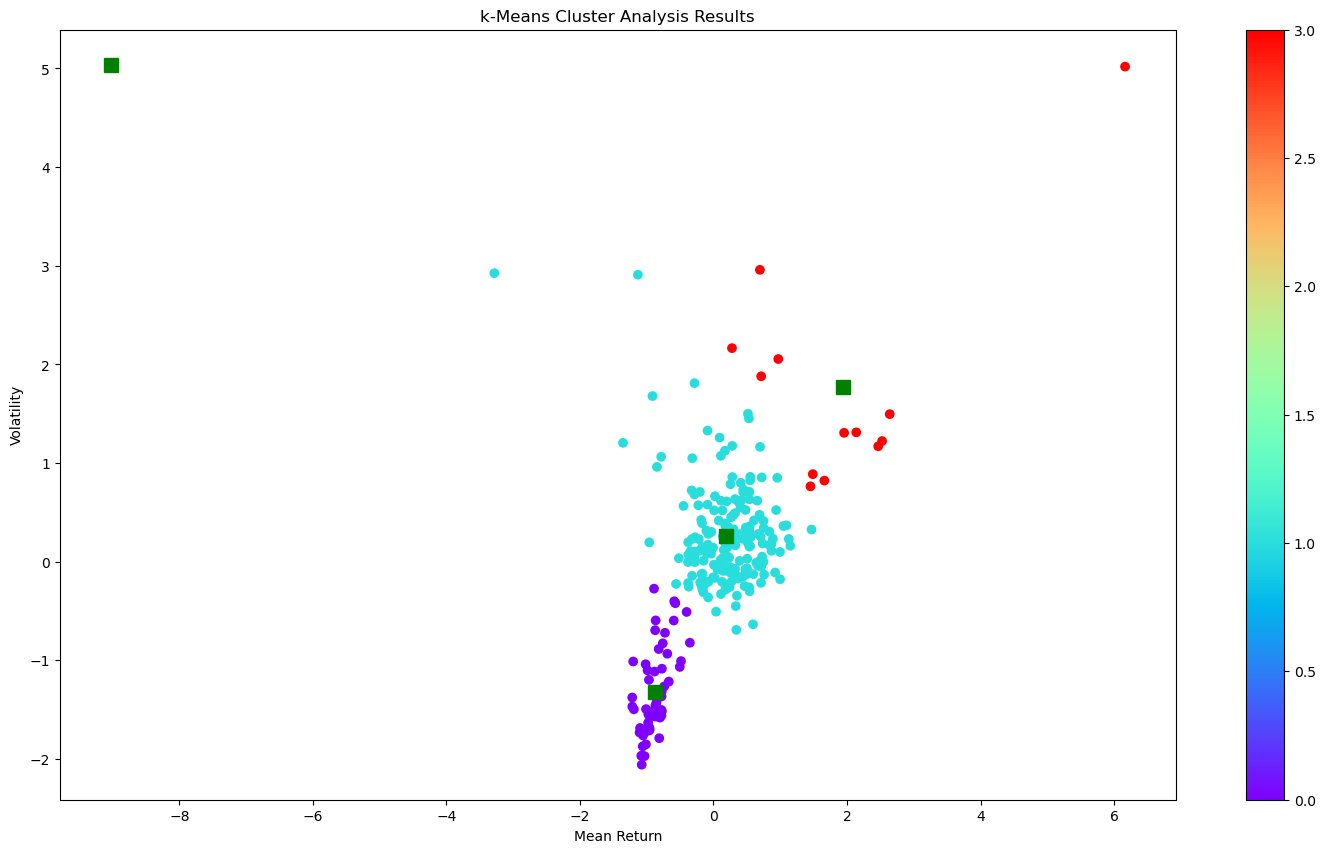

In [21]:
# Show Results
centroids = k_means.cluster_centers_
fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=k_means.labels_, cmap="rainbow", label=X.index)
ax.set_title("k-Means Cluster Analysis Results")
ax.set_xlabel("Mean Return")
ax.set_ylabel("Volatility")
plt.colorbar(scatter)
plt.plot(centroids[:, 0], centroids[:, 1], "sg", markersize=10)
plt.show()

In [22]:
# Returns the Series
clustered_series = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series_all = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]
clustered_series[:15]

AADR    1
AAXJ    1
ACWI    1
ACWX    1
AGNG    1
AGZD    0
AIA     1
AIRR    1
ALTY    1
ANGL    0
ASET    1
BBH     1
BFIT    1
BIB     3
BICK    1
dtype: int32

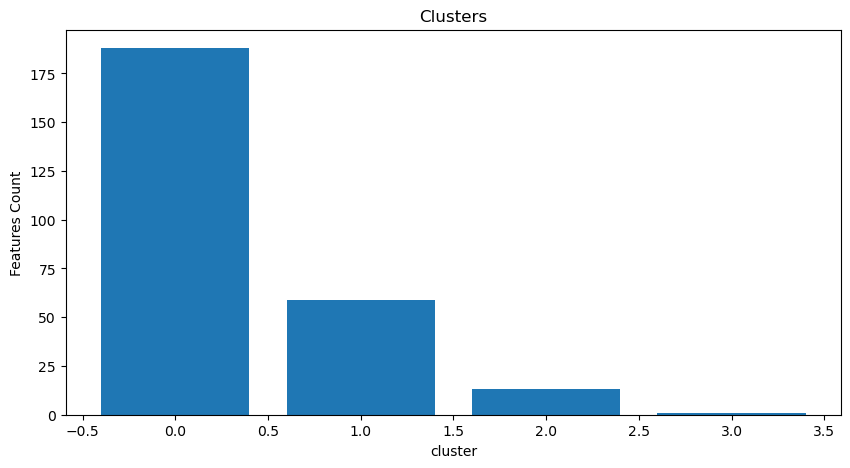

In [24]:
# View number by cluster
plt.figure(figsize=(10, 5))
plt.bar(range(len(clustered_series.value_counts())), clustered_series.value_counts())
plt.title("Clusters")
plt.xlabel("cluster")
plt.ylabel("Features Count")
plt.show()

In [28]:
# Remove Items if Prefeered
clusteres_clean = clustered_series[clustered_series < 3]
print("Feature Number Previous: ", len(clustered_series))
print("Feature Number Current: ", len(clusteres_clean))


Feature Number Previous:  261
Feature Number Current:  248
